# **딥러닝 무작정 따라하기**

## **1. 환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

### (2) 디바이스(device) 준비

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## **2. 데이터 전처리**

### (1) 데이터 전처리1 : 머신러닝과 공통

In [6]:
# 데이터 불러오기
path = 'https://bit.ly/advertising_csv'
adv = pd.read_csv(path)

# x, y 분할
target = 'Sales'
x = adv.drop(target, axis=1)
y = adv.loc[:, target]

# 학습/검증 데이터 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)
print(type(x_train), type(x_val))

# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
print(type(x_train), type(x_val))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### (2) 데이터 전처리2 : 딥러닝에 필요한 전처리

In [8]:
# 텐서 변환
x_train_ts = torch.tensor(x_train, dtype=torch.float32)
y_train_ts = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_val_ts = torch.tensor(x_val, dtype=torch.float32)
y_val_ts = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# 디바이스 할당
x_train_ts, y_train_ts = x_train_ts.to(device), y_train_ts.to(device)
x_val_ts, y_val_ts = x_val_ts.to(device), y_val_ts.to(device)

In [9]:
# 데이터 로더 구성
BATCH_SIZE = 32
train_ds = TensorDataset(x_train_ts, y_train_ts)
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)

## **3. 모델링**

### (1) 모델 선언

In [18]:
# 모델 구조
in_features = x_train_ts.shape[1]
model = nn.Sequential(
    nn.Linear(in_features, 1)
    ).to(device)

In [19]:
# 손실함수와 옵티마이저 구성
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

### (2) 학습

In [20]:
EPOCHS = 100
tr_loss_list, val_loss_list = [], []

# 1. 학습 데이터 반복 학습
for epoch in range(EPOCHS):
    model.train() # 모델 학습 모드
    total_loss = 0.0
    n_batch = 0

    # 2. 에포크마다 배치 단위 학습
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # 3. 학습
        # 오차 순전파: 학습 데이터에서 오차 계산
        pred = model(x) # 모델에 x를 입력해 예측
        loss = loss_fn(pred, y) # 오차 계산

        # 오차 역전파: 오차로부터 가중치 업데이트
        optimizer.zero_grad() # 기울기(gradient) 초기화
        loss.backward() # 손실 함수를 기준으로 각 가중치의 기울기를 계산
        optimizer.step() # 기울기를 기준으로 가중치 조정

        total_loss += loss.item()
        n_batch += 1

    # 에포크마다 학습 오차 집계
    tr_loss = total_loss / n_batch

    # 4. 검증
    model.eval() # 모델 평가/추론 모드
    with torch.no_grad():
        val_pred = model(x_val_ts)
        val_loss = loss_fn(val_pred, y_val_ts)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {epoch+1 : 4d} | train loss {tr_loss:.4f} | val loss {val_loss:.4f}')

Epoch    1 | train loss 230.2874 | val loss 240.3249
Epoch    2 | train loss 226.9394 | val loss 236.8811
Epoch    3 | train loss 223.5096 | val loss 233.4902
Epoch    4 | train loss 220.1472 | val loss 230.1348
Epoch    5 | train loss 216.9498 | val loss 226.7813
Epoch    6 | train loss 213.7027 | val loss 223.4655
Epoch    7 | train loss 210.4078 | val loss 220.2184
Epoch    8 | train loss 207.2072 | val loss 217.0092
Epoch    9 | train loss 204.0826 | val loss 213.8252
Epoch   10 | train loss 200.9517 | val loss 210.6837
Epoch   11 | train loss 197.8372 | val loss 207.5915
Epoch   12 | train loss 194.8706 | val loss 204.5061
Epoch   13 | train loss 191.8270 | val loss 201.4734
Epoch   14 | train loss 188.8153 | val loss 198.4928
Epoch   15 | train loss 185.8817 | val loss 195.5458
Epoch   16 | train loss 183.0088 | val loss 192.6213
Epoch   17 | train loss 180.1345 | val loss 189.7368
Epoch   18 | train loss 177.3658 | val loss 186.8618
Epoch   19 | train loss 174.5075 | val loss 18

### (3) 학습곡선

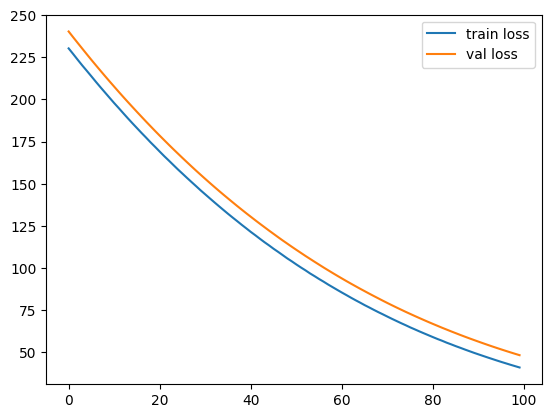

In [21]:
plt.plot(tr_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.legend()
plt.show()

### (4) 예측 및 검증 평가

In [22]:
# 예측
model.eval()
with torch.no_grad():
    pred_val = model(x_val_ts).numpy()

true_val = y_val_ts.numpy()

In [23]:
# 평가
print(f'RMSE : {root_mean_squared_error(true_val, pred_val):.4f}')
print(f'MAE : {mean_absolute_error(true_val, pred_val):.4f}')
print(f'R2 : {r2_score(true_val, pred_val):.4f}')

RMSE : 6.9480
MAE : 5.8072
R2 : -0.3339
